# New code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the data

In [13]:
origindata = pd.read_csv("공대7호관_HV_02.csv")
origindata.drop(['index'], axis=1, inplace=True)
origindata.head()

,date,temperatures(C),humidity(%),pressure(hPa),energy
0,1/1/2021 0:00,-1.8,79.0,1018.5,151.040000
1,1/1/2021 1:00,-2.9,83.0,1018.2,152.272578
2,1/1/2021 2:00,-2.9,81.0,1018.2,151.698984
3,1/1/2021 3:00,-2.8,86.0,1018.6,146.843094
4,1/1/2021 4:00,-2.9,87.0,1018.6,145.536656


In [14]:
from sklearn.impute import SimpleImputer

def fill_0_energy_with_mean(data: pd.DataFrame):
    
    energy = data['energy'].values
    energy[energy == 0] = np.nan
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    energy = imputer.fit_transform(energy.reshape(-1, 1))
    data['energy'] = energy

    return data

In [15]:
processed_data = fill_0_energy_with_mean(origindata)
processed_data['energy'].isnull().values.any()
# check nan

False

### Get features and labels

In [25]:
features = processed_data[['temperatures(C)', 'humidity(%)', 'pressure(hPa)']]

### Train Model

In [26]:
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, Exponentiation, Product

'''
#######
Order: Kernel(xx)-Hyperparameters-Train range-Test range
RBF : 01
Matern: 02
ExpSineSquared : 03
Exponentiation : 04
Constant : 05
Product: 06

ls: length_scale
p: periodicity

tr: train
ts: test
#######
'''

processed_data['date'] = pd.to_datetime(processed_data['date'])

# Compute hours
hours = (processed_data['date'] - processed_data['date'].min()).dt.total_seconds() / 3600

# Train data
train_x_indices = list(range(1, 1000))
train_x = features.iloc[train_x_indices].values  # Reshape for compatibility
train_y = processed_data["energy"].iloc[train_x_indices].values

# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kernel = ExpSineSquared(periodicity=100)+Matern(nu=1.5)
print(kernel.bounds)
print(kernel.n_dims)
print(kernel.theta)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(train_x, train_y)

[[-11.51292546  11.51292546]
 [-11.51292546  11.51292546]
 [-11.51292546  11.51292546]]
3
[0.         4.60517019 0.        ]


c:\Users\197796\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=ExpSineSquared(length_scale=1, periodicity=100) + Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=9)

### Predictions

In [30]:
test_x_indices = list(range(990, 1100))
test_x = features.iloc[test_x_indices].values
test_y = processed_data["energy"].iloc[test_x_indices].values

mean_prediction, std_prediction = gaussian_process.predict(test_x, return_std=True)

### Plot

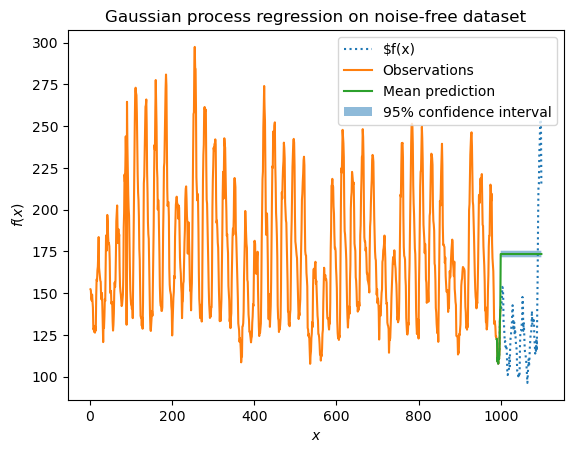

In [35]:
plt.plot(test_x_indices, test_y, label=r"$f(x)", linestyle="dotted")
plt.scatter(train_x_indices, train_y, label="Observations", s=1, color="red")
plt.plot(test_x_indices, mean_prediction, label="Mean prediction")
plt.fill_between(
    test_x_indices,
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian process regression on noise-free dataset")

# # Create 'experiments' folder if it doesn't exist
# folder_path = "experiments"
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# plt.savefig(os.path.join(folder_path,"0302nu15p100tr110000ts999010100.png"), dpi=300)

plt.show()

# An's code

In [1]:
# environment: ts

class cleanData:
    def __init__(self, data):
        self.origindata = data
        self.electdata = self.origindata.copy()

    def check_and_handle_zero_energy_values(self, energy_column_name):
        # Check if values in the energy column are equal to 0
        zero_energy_rows = self.electdata[self.electdata[energy_column_name] == 0]
        if zero_energy_rows.empty: print ("Dataset doesnt contains zero value")
        else:
            print ("Dataset contains zero value")
            self.zero_dataframe = self.create_zero_energy_dataframe(energy_column_name)
            self.delete_zero_energy_row(energy_column_name)

    def delete_zero_energy_row (self, energy_column_name):
        # Delete rows with zero energy
        self.electdata = self.electdata[self.electdata[energy_column_name] != 0]

    def print_zero_energy_row (self, energy_column_name):
        zero_energy_rows = self.electdata[self.electdata[energy_column_name] == 0]
        if not zero_energy_rows.empty:
            print("Rows with zero energy:")
            print(zero_energy_rows)

    def create_zero_energy_dataframe(self, energy_column_name):
        # Create a new DataFrame that stores zero values
        zero_energy_rows = self.electdata[self.electdata[energy_column_name] == 0]
        if not zero_energy_rows.empty:
            return zero_energy_rows.copy()

    def return_copy_of_handled_dataset (self):
        return self.electdata.copy()

# # Read in the file content in a DataFrame called electdata
# origindata = pd.read_csv("공대7호관_HV_02.csv")
#
# checker = cleanData(origindata)
# column_name = 'energy'
# zero_value_data = checker.check_and_handle_zero_energy_values(column_name)
# print (checker.electdata)
# print ("zero value\n",checker.zero_dataframe)
# print ("origindata\n",origindata)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from dataProcessing import cleanData
import os

origindata = pd.read_csv("공대7호관_HV_02.csv")


checker = cleanData(origindata)
column_name = 'energy'
zero_value_data = checker.check_and_handle_zero_energy_values(column_name)
processing_dataset = checker.return_copy_of_handled_dataset()

processing_dataset['datetime_column'] = pd.to_datetime(processing_dataset['date'])
print (processing_dataset)

# Compute hours
hours = (processing_dataset['datetime_column'] - processing_dataset['datetime_column'].min()).dt.total_seconds() / 3600

# Train data
train_x_indices = list(range(1, 10000))
feature1 = hours.iloc[train_x_indices].values.reshape(-1, 1)  # Reshape for compatibility
# tensor_datetime_feature1 = torch.tensor(hours,dtype=torch.float32)
# feature1 = tensor_datetime_feature1[train_x_indices] #hour

train_y = processing_dataset["energy"].iloc[train_x_indices].values

test_x_indices = list(range(9990, 10100))
test_feature1 = hours.iloc[test_x_indices].values.reshape(-1, 1)
test_y = processing_dataset["energy"].iloc[test_x_indices].values

train_x = feature1
test_x = test_feature1


import matplotlib.pyplot as plt

# plt.plot(train_x, train_y, label=r"$f(x) = data function", linestyle="dotted")
# plt.legend()
# plt.xlabel("$x$")
# plt.ylabel("$f(x)$")
# _ = plt.title("True generative process")
#plt.show()

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, Exponentiation, Product

'''
#######
Order: Kernel(xx)-Hyperparameters-Train range-Test range
RBF : 01
Matern: 02
ExpSineSquared : 03
Exponentiation : 04
Constant : 05
Product: 06


ls: length_scale
p: periodicity


tr: train
ts: test
#######
'''

# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kernel = ExpSineSquared(periodicity=100)+Matern(nu=1.5)
print(kernel.bounds)
print(kernel.n_dims)
print(kernel.theta)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(train_x, train_y)

mean_prediction, std_prediction = gaussian_process.predict(test_x, return_std=True)

plt.plot(test_x, test_y, label=r"$f(x)", linestyle="dotted")
plt.scatter(train_x, train_y, label="Observations")
plt.plot(test_x, mean_prediction, label="Mean prediction")
plt.fill_between(
    test_x.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

# # Create 'experiments' folder if it doesn't exist
# folder_path = "experiments"
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# plt.savefig(os.path.join(folder_path,"0302nu15p100tr110000ts999010100.png"), dpi=300)

# plt.show()

Dataset contains zero value
       index             date  temperatures(C)  humidity(%)  pressure(hPa)  \
0          0    1/1/2021 0:00             -1.8         79.0         1018.5   
1          1    1/1/2021 1:00             -2.9         83.0         1018.2   
2          2    1/1/2021 2:00             -2.9         81.0         1018.2   
3          3    1/1/2021 3:00             -2.8         86.0         1018.6   
4          4    1/1/2021 4:00             -2.9         87.0         1018.6   
...      ...              ...              ...          ...            ...   
11204  11204  4/12/2022 20:00             20.5         89.0         1002.4   
11205  11205  4/12/2022 21:00             19.9         92.0         1003.6   
11206  11206  4/12/2022 22:00             19.8         93.0         1003.7   
11207  11207  4/12/2022 23:00             19.4         96.0         1003.4   
11208  11208   4/13/2022 0:00             18.7         97.0         1003.3   

           energy     datetime_colu